In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Sequence Labelling 

Many real-world applications can be cast as *sequence labelling* problems that involve assigning labels to each element in a sequence. For example, in *Part-Of-Speech tagging* each token in a sentence as assigned a part-of-speech such as verb or determiner that indicates the syntactic type of the token. In *Named Entity Tagging* we assign each token with the type of entity the token refers to, such as "Person" or "Organisation", or "None" if the token does not refer to an entity.  

## Sequence Labelling as Structured Prediction

The problem of sequence labelling is an obvious (and somewhat canonical) instance of structured prediction. Here the input space \\(\Xs\\) are sequences of words and the output space $\Ys$ are sequences of output labels. Our goal is again to define a model a model \\(s_{\params}(\x,\y)\\) that assigns high *scores* to the sequence of label \\(\y=y_1 \ldots y_n\\) that fits the input text \\(\x=x_1 \ldots x_n\\), and lower scores otherwise. The model will be parametrized by \\(\params\\), and these parameters we will learn from some training set \\(\train\\) of \\((\x,\y)\\) pairs. In contrast to the classification scenario the prediction problem $\argmax_\y s_{\params}(\x,\y)$ is now non-trivial in general, as we have to search through an exponentional number of label sequences. In practice this issue is overcome by making assumptions about the factorization structure of $s_{\params}(\x,\y)$ and/or search approximations that sacrifice the ability to find the true optimum of the search problem for more expressiveness. 

In this chapter we will restrict ourselves to scoring functions $s_{\params}(\x,\y)$ of the form $\prob_\params(\y|\x)$ that model probability distributions over label sequences $\y$ conditioned on input sequences $\x$. This is the sequence equivalent to conditional models we discussed in the [text classification](doc_classify.ipynb) chapter. Other choices are possible but omitted here they are either very similar (structured SVMs, cite) or less effective in *supervised* sequence labelling (HMMs, cite).   


## Part-of-Speech Tagging as Sequence Labelling
Part-of-Speech (PoS) tagging is an important task within NLP. It is a standard pre-processing step in many tasks. For example, most dependency parsers assume as input PoS tagged sentences. Likewise, [Reverb](reverb), one of the most effective relation extraction methods, defines relations in terms of PoS sequences.

Traditionally, and based on the existence of corresponding annotated training sets, PoS tagging has been applied to quite restricted domains such newswire or biomedical texts. Recently there has been increasing interest in NLP in general, and PoS tagging in particular, for social media data. He we will focus on PoS tagging for tweets and use the [Tweebank dataset](http://www.cs.cmu.edu/~ark/TweetNLP/#pos) and the ["october 27" splits](https://github.com/brendano/ark-tweet-nlp/tree/master/data/twpos-data-v0.3/oct27.splits).

Let us load the data and look at an example tagged sentence.

In [2]:
train = seq.load_tweebank("../data/oct27.splits/oct27.train")
dev = seq.load_tweebank("../data/oct27.splits/oct27.dev")
test = seq.load_tweebank("../data/oct27.splits/oct27.test")
" ".join([w + "/" + t for w,t in zip(train[0][0],train[0][1])])

"I/O predict/V I/O won't/V win/V a/D single/A game/N I/O bet/V on/P ./, Got/V Cliff/^ Lee/^ today/N ,/, so/P if/P he/O loses/V its/L on/P me/O RT/~ @e_one/@ :/~ Texas/^ (/, cont/~ )/, http://tl.gd/6meogh/U"

We have printed the tokens of tweet paired with their PoS tag. The tags (such as "O", "V" and "^") are described in the [Tweebank annotation guideline](http://www.cs.cmu.edu/~ark/TweetNLP/annot_guidelines.pdf). For example, "O" denotes pronouns, "V" verbs and "^" proper nouns. 

In [3]:
# count tags here?`

## Local Models / Classifiers
We will tackle sequence labelling as a (discriminative) structured prediction problem. This means we will build a model $p_\params(\y|\x)$ that computes the conditional probability of output label sequence $\y$ given input sequence $\x$. We will first consider the simplest type of model: a *fully factorised* or *local* model. In this model the probability of $\x$ and $\y$ is a product of *local* probabilities for the label $y_i$ of each token:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

In this model all labels are independent of each other. This assumption has a crucial benefit: inference (and hence training) in this model is trivial. To find the most likely assignment of labels under this model you can find the most likely tag for each token independently. Notice that each local term conditions on the complete input $\x$, not just on $x_i$. This is important, as the sentential context at position $i$ is often important to determine the tag at $i$.     

It is common to indicate this independence structure in a factor graph, a graphical representation of the model. In this representation each variable of the model (our per-token tag labels and the input sequence $\x$) is drawn using a circle, and *observed* variables are shaded. Each factor in the model (terms in the product) is drawn as a box that connects the variables that appear in the corresponding term. For example, the term $p_\params(y_3|\x,3)$ would connect the variables $y_3$ and $\x$. 

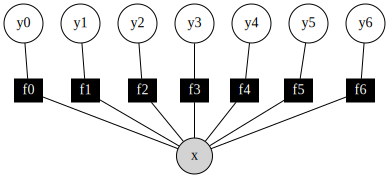

In [4]:
seq.draw_local_fg(7)

The independence assumptions of this model allow us to think of it not as a single sequence model, but a sequence of classification models. We have a classifier $p_\params(y|\x,i)$ that predicts the best class/tag for a token based on its sentence $\x$ and position $i$.

$$
  p_\params(y|\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

Let us define a simple version of this model on the PoS tagging task defined above. Here we use a feature function (template) that has one active feature corresponding to the word $x_i$ observed at index $i$. 

In [5]:
def feat_1(x,i):
    return {
        'word':x[i]
    }
local_1 = seq.LocalSequenceLabeler(feat_1, train)

Notice that in the above feature functions return a dictionary mapping a feature name (`word`) to a feature value (`x[i]`, the word at index `i`). This is not quite what we require `repr(\x,i)` to be, namely a function from $\x$ and $i$ to a real feature vector. However, internally this dictionary-based representation can be transformed into the desired form by defining a feature function template like so:

$$
f_{\text{word},w}(\x,i) = \indi\left[x_i = w\right]
$$

This means that we have one feature function $f_{\text{word},w}$ per word $w$. For example, the feature function $f_{\text{word},\text{"the"}}$ returns $1$ if $x_i = \text{"the"}$ and $0$ otherwise.  

We can assess the accuracy of this model on the development set.

In [6]:
seq.accuracy(dev, local_1.predict(dev))

0.6995645863570392

This is a good start, but a macro-level evaluation score does not really show us where the approach fails and can be improved. One alternative view on the system is a confusion matrix that shows, for each pair of labels $l_1$ and $l_2$, how often $l_1$ was classified as $l_2$.    

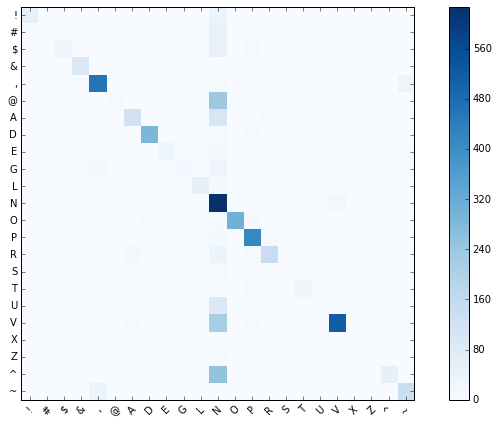

In [7]:
seq.plot_confusion_matrix(dev, local_1.predict(dev))

This matrix shows a couple of interesting properties of our current model. First, we notice a relatively strong diagonal. This corresponds to correctly predicted labels and is a good sign. We also notice the 'N' (common nouns) column that receives a lot of counts. This means that many words that aren't common nouns are labelled as common nouns. This may not be surprising, as the large frequency of common nouns in the data (observe the very dark 'N'-'N' dot) could have 'N' the default class, chosen whenever there is too much uncertainty. 

The matrix enables us to spot systematic problems that, if fixed, may lead to substantial improvements. One problem is the fact that '@' (used for tokens that address twitter user ids) is never labelled correctly (its diagonal entry is missing). Why could this be? To investigate this further it is useful to look at the learned weight vector for this class.  

In [8]:
local_1.plot_lr_weights('@')

ValueError: bad input shape ()

We see features for specific users such as "word=@justinbieber" corresponding to the feature function $f_{\text{word},\text{"@justinbieber"}}$. This is all the model can do right now: remembering words from the training set. This works for "@justinbieber", but for less popular twitter accounts that are unlikely to appear in the training set this means we cannot correctly classify them at test time. In other words, the model does not generalise well.  

In this particular case the problem can be easily solved. We notice that each of the "@" words starts (obviously) with a "@" symbol. If we turn this observation into a feature it should be simple to learn the class. We can do this by introducting a new feature `first_at` which returns `True` if $x_i \text{ starts with @}$ and `False` otherwise. Internally this is again transformed into a proper real-valued feature template.

In [ ]:
def feat_2(x,i):
    return {
        **feat_1(x,i),
        'first_at':x[i][0:1] == '@'
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

This looks much better. Of course this particular aspect of the problem is so deterministic that we could simply preprocess all words starting with @ and label them as '@' right away. But is important to know how easy such observations can be incorporated into the probabilistic model. 

To confirm that these results actually from improved '@' prediction, let us look at the confusion matrix again.

In [ ]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Clearly, and unsurprisingly, we are now doing very well at predicting '@' labels. We can check that the model learned what we expected by also replotting its weight. (Exercise: figure out what happened to "Deja_fckn_Vu"). 

In [ ]:
local_2.plot_lr_weights('@')

There are other rows in the confusion matrix with empty diagonal entries, suggesting problems. But another approach to improving the system is to look for errors with high frequency. On such error corresponds to the problem of distinguishing proper nouns (label '^') such as "McDonals" or "smash burger" from common nouns (label 'N') such as "wife" or "rain". 

To better understand this problem it is useful to look at some actual predictions of the model where this error occurs. In particular, if we show for each error both the context of this error (say, the surrounding words) as well as the used feature representation, we can both spot potential bugs and get inspiration for additional features. In fact, **this type of debugging and sanity checking should be performed for any model you ever train**. Even if (or maybe: in particular when) your model is doing well it is worth to perform this type of micro analysis to spot potential bugs that lead to worse performance, or bugs that effectively mean you are cheating (e.g. because you are using gold data at test time).     

In [ ]:
util.Carousel(local_2.errors(dev[:10], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='^'))

By inspecting proper noun instances in this way we can notice that proper nouns tend to be capitalised. This suggests that the model could benefit from a feature representation that captures whether a word starts with a lower or upper case character. Indeed, adding such feature leads to better performance.

In [ ]:
def feat_3(x,i):
    return {
        **feat_2(x,i),
        'is_lower':x[i].islower()
    }
local_3 = seq.LocalSequenceLabeler(feat_3, train, C=10)
seq.accuracy(dev, local_3.predict(dev))

This improvement indeed comes from being able to identify proper nouns when they are capitalised. This can be observed when inspecting the corresponding errors: some of previous errors are now fixed, and the specific error count on the first 10 development instances has reduced from 7 to 3. 

In [ ]:
util.Carousel(local_3.errors(dev[:10], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='^'))

Let us look for further problems we could fix with more features, and consider the confusion matrix of the current model.

In [ ]:
seq.plot_confusion_matrix(dev, local_3.predict(dev))

Another high frequency error stems from misclassifying verbs ('V') as common nouns ('N'). We can understand these errors better by again inspecting examples. 

In [ ]:
util.Carousel(local_3.errors(dev[:20], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='V'))

We find a couple of errors where verbs like "laughing", "blowing" or "passed" are misclassified as common nouns. When looking at the features of those instances, and the corresponding weights, we see that for $f_{\text{word},w}$ feature template weights are $0$. This usually suggests that the word has not appeared (or not appeared as a verb) in the training set. However, we can tell that these words may be verbs without having to have seen them before because they come with standard verb suffixes such as "ing" or "ed". We can easily test for such cases by incorporating features that look at length two and three suffixes of the target token.

In [ ]:
def feat_4(x,i):
    return {
        **feat_3(x,i),
        'last_3': "".join(x[i][-3:]),
        'last_2': "".join(x[i][-2:]),
    }
local_4 = seq.LocalSequenceLabeler(feat_4, train)
seq.accuracy(dev, local_4.predict(dev))

In [ ]:
util.Carousel(local_4.errors(dev[:20], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='V' ))

This indeed removed the earlier mistakes for unseen verbs.

## Maximum Entropy Markov Models (MEMM)

There is an observation we have not made use of. For PoS tagging as well as many other sequence labelling tasks we often have *dependencies* between consecutive labels. For example, after a non-possessive pronoun ("O") such as "you" a verb is more likely than a noun. This means that the current label $y_i$ does not only depend on the observation $\x$ and index $i$, but also on the previous label $y_{i-1}$ (or even labels further in the past). Our *local* model above cannot capture this. 

One simple extension to the local model is the [Maximum Entropy Markov Model (MEMM)](http://www.ai.mit.edu/courses/6.891-nlp/READINGS/maxent.pdf). This model can again be understood as a product of local logistic regression (aka Maximum Entropy) classifiers $\prob_\params(y_i|\x,y_{i-1},i)$, but now each of these classifiers can use the previous label as observed feature and hence makes a first-order Markov assumption. Let $y_0=\text{PAD}$ be padding for the label sequence to operate properly $\prob_\params(y_1|\x,y_{0},i)$, then the MEMM defines the following distribution over   

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,y_{i-1},i)
$$

The individual terms are defined as log-linear models as before, this time with access for features to the previous label: 

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x,y_{i-1},i}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where $Z_{\x,y_{i-1},i}=\sum_y \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle $ is a *local* per-token normalisation factor.

We show the factor graph of this model below. The observed "P" node corresponds to out setting of $y_0=\text{PAD}$. 

In [ ]:
seq.draw_transition_fg(7)

### Training MEMMs
We can train MEMMs by optimising the conditional likelihood of the gold label sequences, $\sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x)$. This objective can be formulated as follows:

$$
\sum_{(\x,\y) \in \train} \sum_{i=1}^{|\x|} \log \prob_\params(y_i|\x,y_{i-1},i)   
$$

The objective is equivalent to a logistic regression objective for a classifier that assigns labels based on previous gold labels. This makes MEMMs easy to train: one can simply use a logistic regression classifier library and prepare a list of classifier training instances by iterating over all sequences and then generating one training instance per token.   

TODO: This reliance on gold labels at training time is a problem we will discuss in more detail later. On the other hand, it makes training MEMMs very easy and fast.   

### Prediction in MEMMs
To predict the best label sequence we need to find a $\y^*$ with maximal conditional probability given the observed word sequence $\x$:

$$
\y^* =\argmax_\y \prob_\params(\y|\x).
$$

Due to the label dependencies, we cannot simply choose each label in isolation in order find the maximum. One solution to this problem is a forward greedy method:

1. set $y_0 \leftarrow \text{PAD}$
1. for $i$ in $1 \ldots |\x|$:
    1. $y_i \leftarrow \argmax_{y} \prob_\params(y|\x,y_{i-1},i)$
    
This is an approximation because you can choose a locally optimal $y_i$ but for choosing the next $y_{i+1}$ a different previous $y_i'$ could have led to a much higher aggregate probability. In other words, you may find that 

$$
\prob_\params(y_i'|\x,y_{i-1},i) \prob_\params(y_{i+1}'|\x,y_i',i) > \prob_\params(y_i|\x,y_{i-1},i)\prob_\params(y_{i+1}|\x,y_i,i)
$$ 

even though $\prob_\params(y_i|\x,y_{i-1},i) > \prob_\params(y_i'|\x,y_{i-1},i)$. We will address this issue later.

We provide an implementation of MEMMs, wrapping around a Scikit-Learn logistic regression model, in `seq.MEMMSequenceLabeler`. Below we first implement the greedy prediction algorithm above using this class. The class provides a local `predict_next` method that chooses the best label conditioned on a previous label. With this function at hand the greedy prediction algorithm is easy:

In [ ]:
def memm_greedy_predict(memm: seq.MEMMSequenceLabeler, data, use_gold_history=False):
    result = []
    for x, y in data:
        y_guess = []
        for i in range(0, len(x)):
            prediction = memm.predict_next(x, i, y_guess if not use_gold_history else y)
            y_guess.append(prediction)
        result.append(y_guess)
    return result

Now we are ready to define a specific MEMM model. To specify the model we need to define its feature function. We use the feature function from before, assessing only $\x$ and $i$, and append to it (see the `**feat_4(x,i)` notation) a new feature that captures the first item of the label history so far. Notice that we could assess labels further in the past (after increasing the `order` appropriately) but leave this for the reader to test. 

In [ ]:
def memm_feat_1(x,i,hist):
    return {
        **feat_4(x,i),
        'prev_y': hist[0],
#          'prev_nom': hist[0] in {'N','^','O','S','Z'}
    }

memm_1 = seq.MEMMSequenceLabeler(memm_feat_1, train, order=1, C=10)
seq.accuracy(dev,memm_greedy_predict(memm_1, dev))

We have improved the predictions even further, and did avoid some of the verb mistakes we observed earlier. To illustrate this let us consider the remaining errors on the development subset used earlier. We see that instead of 5 errors we now encounter only 3. 

In [ ]:
util.Carousel(seq.errors(dev[:20], memm_greedy_predict(memm_1, dev[:20]), 'V', 'N',model=memm_1))

We should also inspect what transition weights the model learnt. For the case of verbs ('V') we observe a high weight for $f_{\text{prev_y},\text{O}}$, indicating that pronouns are often followed by verbs, as we expected earlier.   

In [ ]:
memm_1.plot_lr_weights('V',feat_filter=lambda s: s.startswith("prev_"))

### Beam Search
As we discussed, the greedy search approach is an approximate solution to the $\argmax$ problem. One way to improve over greedy search is to maintain a *beam* of $k$-best solutions in each step. This enables initially weaker solutions to remain in the beam and move up the ranks in later steps in case they are more consistent with future observations. 

Technically a $k$-best beam search proceeds as follows. Let $L$ be the label set.

1. Initialise a beam $B \leftarrow \left[(\text{PAD}, 0) \right]$ of partial solutions $(\y,s)$ where $s$ is the partial log-score of $\y$. 
1. **for** $i$ in $1 \ldots |\x|$:
    1. Let $C\leftarrow \{\}$ be the next beam candidates.
    1. **for** $\y, s$ in $B$ and $y$ in $L$: 
        1. $C \leftarrow C \cup \{ (\y \| y, s + \log \prob_\params(y|\x,y_{i-1},i)) \} $
    1. Let $B\leftarrow k\text{-highest-scoring}(C)$ be the $k$ pairs $(\y, s)$ with highest scores.
1. **Return** $\y$ with highest score in $B$. 

Note that a slightly faster version can use a priority queue. 

In Python we can implement this algorithm like so:

In [ ]:
def memm_beam_search(memm, x, width=2):
    beam = [([],0.)]
    history = [beam]
    for i in range(0, len(x)):
        # use priority queue 
        candidates = []
        for (prev,score) in beam:
            scores = memm.predict_scores(x, i, prev)
            for label_index,label_score in enumerate(scores):
                candidates.append((prev + [memm.labels()[label_index]], score + label_score))
        beam = sorted(candidates, key=lambda x: -x[1])[:width]
        history.append(beam)
    return beam, history
            
def batch_predict(data, beam_predictor):
    return [beam_predictor(x)[0][0][0] for x,y in data]

seq.accuracy(dev, batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 10)))

With beam of size 10 accuracy improves only marginally. You can try other beam sizes (leading to longer runtimes) but likely will not see substantial improvements. Is this because we already finding solutions with highest probability, or because higher probability doesn't necessarily mean higher accuracy? 

We can test how many per-token predictions differ when comparing greedy search to a beam search of a given width, simply calculating their accuracies relative to each other:

In [ ]:
seq.accuracy(memm_greedy_predict(memm_1, dev), batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 10)))

We notice that about 4% of the tokens receive different labels, simply searching for higher scoring sequences. This suggest that we frequently find higher probability sequences, but that these are not necessarily more correct. We can also calculate the average log probability of the argmax sequence using different beam sizes. Again we see that there is a substantial difference between scores, they are just not reflected in task accuracy. 

In [ ]:
sum([memm_beam_search(memm_1, x, 1)[0][0][1] for x,y in dev]) / len(dev)

In [ ]:
sum([memm_beam_search(memm_1, x, 5)[0][0][1] for x,y in dev]) / len(dev)

TODO: Relate to findings in literature that suggest the same or make related observations.

Beam search is a simple and often effective way to find sequences (or other structures) with higher probability. However, often it is also inefficient in the sense that it does not fully leverage the factorisation structure and conditional independences. To illustrate this problem recall that the conditional probability of a label $y_i$ only depends on the previous label $y_{i-1}$, any earlier labels have no impact on the term $\prob(y_i|\x,y_{i-1},i)$. With this in mind let us follow the beam for an example instance.     

In [ ]:
example = 56
beam, history = memm_beam_search(memm_1, dev[example][0],3)
seq.render_beam_history(history, dev[example], end=17)

Notice the search *frontier*, the most recent label in each of the hypotheses, often has very little diversity. Sometimes this makes sense: for the word "of" it is very certain that the label "P" for preposition should be assigned, and the frontier reflects that. However, for the adjective "better" of "better way" the frontier contains the label "R" (adverb) twice, and the gold label "A" (adjective) not at all. This leads to an error in this case. We can fix this error by simply increasing the beam size to 4. You can test this above. In this case "A" barely makes it into the beam, and becomes the winning label in the next step as it fits better to the noun "way". 

One can generally avoid search errors by increasing the width, but for many models this is sub-optimal because it ignores the factorization or dependency structure of the model. In this particular case labels only depend on the previous label. This means that it makes no sense to maintain more than one hypothesis with the same frontier label in the beam. One only needs to remember the highest scoring sequence with that frontier label. To prove this consider two partial sequences $\y$ and $\y'$ of length $l$ with the same last label $t=y_l=y'_l$. Assume that the log probability $s = \sum_{i}^0 \log \prob(y_i|\x,y_{i-1},i)$  of $\y$ is larger than the log probability $s' = \sum_{i}^0 \log \prob(y'_i|\x,y'_{i-1},i)$ of $\y'$. Further assume that the label $y_{l+1}$ maximises $\prob(y_{l+1}|\x,t,i+1)$. Then the log probability of $\y \| y_{l+1}$ is larger than the log probability of $\y' \| y_{l+1}$ and hence there is no need to carry around $\y'$.   

### Viterbi 

The Viterbi (link/cite) algorithm leverages conditional independences of the model directly. It does so by maintaining a map $\alpha_i(l)$ from label $l$ and token index $i$ to the score $\log \prob(\y|\x)$ of highest scoring sequence $\y$ ending in label $l$ at token $i$. For each pair $(l,i)$ we also remember the sequence $\y$ that yielded that score in a map $\beta_i(l)$. The algorithm initialises $\alpha_{1}(l) =\log \prob(l|\x,\text{PAD},1)$ and then updates the $\alpha$ map via the following recursion:

$$
\alpha_i(l) = \max_y \alpha_{i-1}(y) + \log \prob(l|\x,y,i)  
$$

and in $\beta_i(l)$ we store the 'winning' $y$ from the $\max$ term. Once we reached the sequence end the result sequence can be inferred by finding the label $l$ with highest $\alpha_{|\x|}(l)$ and then back-tracking using $\beta$. It is easy to show that this algorithm returns the *optimal* solution to the prediction/search problem, assuming that labels only depend on the previous label. (Exercise: extend to $n$ previous labels) 

Below we implement a beam version of the viterbi algorithm. In this version we restrict the maximisation that defines $\alpha_i(l)$ to only range over the top $k$ highest scoring previous labels $y$.   

In [ ]:
from collections import defaultdict
import math
def memm_viterbi_search(memm, x, width=2):
    labels = memm.labels()
    # initialise
    alpha = [{}]
    beta = [{}]
    for label_index, label_score in enumerate(memm.predict_scores_hist(x, 0, ["PAD"])):
        label = labels[label_index]
        alpha[0][label] = label_score
        beta[0][label] = "PAD"
    
    # prune
    seq.prune_alpha_beta(alpha[0], beta[0], width)
    
    # recursion 
    for i in range(1, len(x)):
        alpha.append(defaultdict(lambda: -math.inf))
        beta.append({})
        for p in alpha[i-1].keys():
            for label_index, label_score in enumerate(memm.predict_scores_hist(x, i, [p])):
                label = labels[label_index]
                new_score =  alpha[i-1][p] + label_score
                if new_score > alpha[i][label]:
                    alpha[i][label] = new_score
                    beta[i][label] = p
        # prune
        seq.prune_alpha_beta(alpha[i], beta[i], width)
    
    # convert to beam history to be used in the same way beam search was used.  
    history = seq.convert_alpha_beta_to_history(x, alpha, beta)
    return history[-1], history

beam, history = memm_viterbi_search(memm_1, dev[example][0],3)
seq.render_beam_history(history, dev[example], 17)

Crucially, for the same beam size we now keep the correct labelling of "better" in the beam and reach a better solution, both in terms of log probability and actual accuracy. 

This improvement in log probabilities does not always lead to higher global accuracy:

In [ ]:
seq.accuracy(dev, batch_predict(dev, lambda x: memm_viterbi_search(memm_1, x, 10)))

## Label Bias Problem

MEMMs multiply several *locally* normalised transition probabilities to arrive at a sequence probability. That is, for each token $i$ and a given previous state $y_{i-1}$ the sum of transition scores into next states $\sum_{y_i} \prob_\params(y_i|\x,y_{i-1},i)$ equals 1. This local normalisation makes training easy (why?), but it also leads to a problem. Consider two simple sequences "that works" and "that house". The former is a pronoun ("O") followed by a verb ("V"), the latter is a determiner ("D") followed by a noun ("N"). Let us assume that 

$$
\prob_\params(\text{D}|\x,\text{PAD},0) =\prob_\params(\text{O}|\x,\text{PAD},0) \approx 0.5,
$$

meaning that at the beginning of a sentence both the determiner and pronoun label for "that" have roughly the same probability 0.5. Now assume that in the training set determiners are always followed by nouns, and pronouns always by verbs. This would mean that 

$$
\prob_\params(\text{N}|\x,\text{D},i) = \prob_\params(\text{V}|\x,\text{O},i)  \approx 1
$$     

and hence transitions from these two states are completely independent of the observation. 

Now we have $\prob_\params(\text{D N}|\, \text{that works}) \approx 0.5$ and $\prob_\params(\text{O V}|\, \text{that works}) \approx 0.5$, and the same for the input "that house". This means that once we enter the "D" or "O" state, the following observations have no effect on the sequence probability. The reason is that MEMMs requires *all* incoming probability mass (0.5 in the above example) to a given state (such as "D" or "O") to be distributed among the outgoing states. If there is only one possible next state, then that next state will receive all the mass, regardless of the observation. In particular, the model cannot say "in state "D" and for observation "works", *all* labels are impossible. More generally, states with few outgoing distributions effectively ignore observations, and this creates a bias towards such states. This problem is known as the *label bias problem*. 

## CRF

[Conditional Random Fields (CRFs)](http://www.seas.upenn.edu/~strctlrn/bib/PDF/crf.pdf) have been developed to overcome the label bias. The core problem of MEMMs is local normalisation. CRFs replace this with *global* normalisation. That is instead of normalising across all possible next states $y_{i+1}$ given a current state $y_i$ and observation $\x$, the CRF normalises across all possible *sequences* $\y$ given observation $\x$. Formally the CRF is hence defined as follows:

$$
p_\params(\y|\x) = \frac{1}{Z_{\x}} \prod_i^{|\x|} \exp  \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle
$$

where $Z_{\x}=\sum_\y   \prod_i^{|\x|} \exp \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ is the *partition function*, a *global* normalisation constant depending on $\x$. Notably each term $\exp  \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ in the product can now take on values in $[0,\infty)$ as opposed to the MEMM terms in $[0,1]$.  

The name CRF stems from the fact they correspond to [Markov random fields](http://www.statslab.cam.ac.uk/~grg/books/hammfest/3-pdc.ps), globally conditioned on the observation $\x$. While in this chapter we focus on cases where the dependency structure corresponds to a linear chain, CRFs are more general and encompass any graphical structure. 

### Training Linear Chain CRFs

CRFs can be trained (as usual) by maximising the conditional log-likelihood of the data 

$$
CL(\params) = \sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x).
$$

This is substantially harder than for MEMMs because the partition function makes it impossible to break up the objective into only per-token logistic regression terms. Instead the objective needs to be treated on a per-sequence basis. Conceptually this is not difficult: just as for logistic regression we need to calculate the gradient of the objective, and once we have this gradient, we choose a gradient descent/ascent method to optimise the function. The general CRF conditional log-likelihood is in fact a generalisation of the logistic regression objective, and hence the CRF gradient will look very similar to the gradient of logistic regression. We discuss this gradient, its derivation and calculation in more detail [TODO](todo). In this chapter we will only briefly discuss the gradient and what is necessary to calculate it. 

\begin{split}
  \nabla_{y'} CL(\params) =  \sum_{(\x,\y) \in \train} \sum^{|\x|}_i\repr(\x,y_{i-1},i) \delta(y_i,y') - p_\params(y',y_{i-1}|\x) \repr(\x,y_{i-1},i) 
\end{split}


### Prediction in Linear Chain CRFs

From the perspective of finding $\argmax_\y \prob_\params(\y|\x)$ we can treat the CRF just as the MEMM. The share the same factorisation/dependency structure and are just differently normalised. That is, we can again simply perform greedy search, use a beam or apply Viterbi. 

Below we train a CRF model using the same feature vectors as used for the MEMM model, and then do prediction via the Viterbi algorithm (this is the standard algorithm in most CRF libraries). 

In [ ]:
crf_1 = seq.CRFSequenceLabeler(feat_4, train)
seq.accuracy(dev, crf_1.predict(dev))

A notable 1% point improvement over the MEMM model that essentially comes from free in the sense that we are using exactly the same feature representation and are just changing from local to global normalisation.

## Test

In [ ]:
util.Table([
        ["word", seq.accuracy(test, local_1.predict(test))],
        ["+ first @", seq.accuracy(test, local_2.predict(test))],
        ["+ cap", seq.accuracy(test, local_3.predict(test))],
        ["+ suffix", seq.accuracy(test, local_4.predict(test))],
        ["MEMM", seq.accuracy(test, memm_1.predict(test))],
        ["CRF", seq.accuracy(test, crf_1.predict(test))]       
    ])

## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Simple Sentiment Classification](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) ???